In [ ]:
pip install s3fs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Reshape, Input, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df = pd.read_csv('s3://skysquad/DATASET/zurich_dataset.csv')
df_1= df.copy()

def calculate_index(group):
    """Calculates the index based on 'flight_id', 'lastseen', and 'timedelta'"""
    group = group.sort_values('timedelta')  # Sort within groups by timedelta
    group['index'] = range(1, len(group) + 1)  # Assign the index
    return group

# Apply the calculation to groups based on 'flight_id' and 'lastseen'
df = df.groupby(['flight_id']).apply(calculate_index)



df.describe()

,altitude,geoaltitude,groundspeed,latitude,longitude,distance,runway,initial_bearing,track_unwrapped,x,y,timedelta,index
count,71400.000000,70000.000000,71400.000000,71400.000000,71400.000000,71400.000000,71400.0,71400.000000,71400.000000,71400.00000,7.140000e+04,71400.000000,71400.00000
mean,9396.761917,9519.755357,245.503466,47.448484,8.618264,15.820186,34.0,181.316006,198.675713,471211.82180,5.255228e+06,538.760504,100.50000
std,4772.387226,4815.428025,64.907899,0.208800,0.323547,9.432438,0.0,78.019344,148.503632,24368.53320,2.321372e+04,343.748079,57.73471
min,1250.000000,1475.000000,109.590051,46.806290,7.577397,0.426749,34.0,34.533984,-386.399934,392973.17200,5.183786e+06,0.000000,1.00000
25%,5525.000000,5600.000000,194.239375,47.300491,8.557082,8.947006,34.0,102.428740,120.454797,466616.46950,5.238724e+06,256.000000,50.75000
50%,9250.000000,9350.000000,245.617377,47.404861,8.640254,13.927784,34.0,189.256912,181.005086,472871.43745,5.250370e+06,515.000000,100.50000
75%,13000.000000,13200.000000,289.347292,47.568192,8.773780,20.696456,34.0,247.515753,290.588616,482930.17970,5.268758e+06,777.000000,150.25000
max,30800.000000,30025.000000,481.614575,48.129474,9.524803,39.955694,34.0,352.139815,1057.306205,539504.65950,5.330907e+06,2248.000000,200.00000


In [ ]:
column_names = ['index', 'min_longitude', 'max_longitude', 'mean_longitude',
                'min_latitude', 'max_latitude', 'mean_latitude',
                'min_a  ltitude', 'max_altitude', 'mean_altitude',
                'min_ground_speed', 'max_ground_speed', 'mean_ground_speed']

# Create an empty DataFrame
range_df = pd.DataFrame(columns=column_names)

# Define the statistics you want to calculate
statistics = ['min', 'max', 'mean']

# Columns to calculate statistics on
data_columns = ['longitude', 'latitude', 'altitude', 'groundspeed']

# Create an empty DataFrame to store the results
result_df = pd.DataFrame()

# Loop through indices from 1 to 200
for index in range(1, 201):
    # Filter data for the current index
    filtered_df = df[df['index'] == index]

    # Skip if there's no data for this index
    if filtered_df.empty:
        continue

    # Calculate statistics
    for col in data_columns:
        for stat in statistics:
            result_df.loc[index, f'{col}_{stat}'] = getattr(filtered_df[col], stat)()

result_df

,longitude_min,longitude_max,longitude_mean,latitude_min,latitude_max,latitude_mean,altitude_min,altitude_max,altitude_mean,groundspeed_min,groundspeed_max,groundspeed_mean
1,7.577397,9.524803,8.566108,46.806290,48.129474,47.695498,12975.0,30800.0,17629.411765,228.034888,481.614575,340.581897
2,7.587227,9.516273,8.565579,46.811115,48.123516,47.692794,12975.0,30700.0,17525.023343,228.054621,480.350498,339.394675
3,7.596771,9.509583,8.565117,46.815720,48.116533,47.690116,12975.0,30600.0,17421.352708,228.054621,478.137642,338.201402
4,7.606384,9.501413,8.564709,46.819656,48.111505,47.687237,12975.0,30500.0,17317.857143,228.078737,476.563330,337.090580
5,7.614863,9.493244,8.564263,46.824336,48.106570,47.684358,12975.0,30350.0,17215.721289,228.078737,475.302651,335.902087
...,...,...,...,...,...,...,...,...,...,...,...,...
196,8.562293,8.575252,8.566134,47.418575,47.437382,47.431839,1475.0,2550.0,1876.995798,115.870517,163.719131,142.596093
197,8.561096,8.570778,8.563914,47.425186,47.439198,47.435074,1425.0,2450.0,1798.494398,114.965113,164.200954,142.392434
198,8.559899,8.566660,8.561689,47.431051,47.440920,47.438302,1375.0,2350.0,1718.592437,114.127024,164.200954,142.266406
199,8.558350,8.561730,8.559472,47.438267,47.443039,47.441525,1312.5,2250.0,1640.091036,114.542469,164.623671,142.238134


In [ ]:
!pip install tensorflow-addons


In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


# Extract min and max values from result_df for constraints
min_values = result_df[['longitude_min', 'latitude_min', 'altitude_min', 'groundspeed_min']].values.reshape(1, 200, 4)
max_values = result_df[['longitude_max', 'latitude_max', 'altitude_max', 'groundspeed_max']].values.reshape(1, 200, 4)

# Define the generator model with constraints
def build_generator_rnn(latent_dim, num_points, num_features, min_values, max_values):
    input_layer = layers.Input(shape=(latent_dim,))
    reshaped_input = layers.Reshape((1, latent_dim))(input_layer)
    lstm1 = layers.LSTM(128, return_sequences=True)(reshaped_input)
    lstm2 = layers.LSTM(256, return_sequences=True)(lstm1)
    output_layer = layers.TimeDistributed(layers.Dense(num_features))(lstm2)  # Output includes longitude, latitude, altitude, and groundspeed

    # Apply constraints to the output
    constrained_output = layers.Lambda(lambda x: x * (max_values - min_values) + min_values)(output_layer)

    model = models.Model(inputs=input_layer, outputs=constrained_output)
    return model

# Define latent dimension, number of points, and number of features
latent_dim = 100
num_points = 200  # Assuming each flight track has 200 data points
num_features = 4  # Assuming you have longitude, latitude, altitude, and groundspeed as features

# Build the generator model with constraints
generator_rnn = build_generator_rnn(latent_dim, num_points, num_features, min_values, max_values)

# Compile the generator model with Wasserstein loss and Adam optimizer
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
generator_rnn.compile(optimizer=generator_optimizer, loss='mse')  # Using mean squared error (MSE) loss

# Prepare your training data X_train in the required shape [batch_size, num_points, num_features]
X_train = df[['longitude', 'latitude', 'altitude', 'groundspeed']].values.reshape(-1, num_points, num_features)

# Define training parameters
epochs = 500
batch_size = 128

# Training function
def train(generator, X_train, epochs, batch_size):
    for epoch in range(epochs):
        # Generate synthetic flight tracks
        noise = np.random.normal(0, 1, (len(X_train), latent_dim))
        gen_tracks = generator.predict(noise)

        # Train the generator (not implemented here)
        # gan.train_on_batch(noise, X_train)

        # Progress logging
        print(f"Epoch: {epoch+1}/{epochs}")

# Start training
train(generator_rnn, X_train, epochs, batch_size)

12/12 [==============================] - 2s 9ms/step
Epoch: 1/500
12/12 [==============================] - 0s 9ms/step
Epoch: 2/500
12/12 [==============================] - 0s 8ms/step
Epoch: 3/500
12/12 [==============================] - 0s 8ms/step
Epoch: 4/500
12/12 [==============================] - 0s 9ms/step
Epoch: 5/500
12/12 [==============================] - 0s 7ms/step
Epoch: 6/500
12/12 [==============================] - 0s 5ms/step
Epoch: 7/500
12/12 [==============================] - 0s 8ms/step
Epoch: 8/500
12/12 [==============================] - 0s 8ms/step
Epoch: 9/500
12/12 [==============================] - 0s 7ms/step
Epoch: 10/500
12/12 [==============================] - 0s 7ms/step
Epoch: 11/500
12/12 [==============================] - 0s 11ms/step
Epoch: 12/500
12/12 [==============================] - 0s 7ms/step
Epoch: 13/500
12/12 [==============================] - 0s 8ms/step
Epoch: 14/500
12/12 [==============================] - 0s 8ms/step
Epoch: 15/500
12/

12/12 [==============================] - 0s 6ms/step


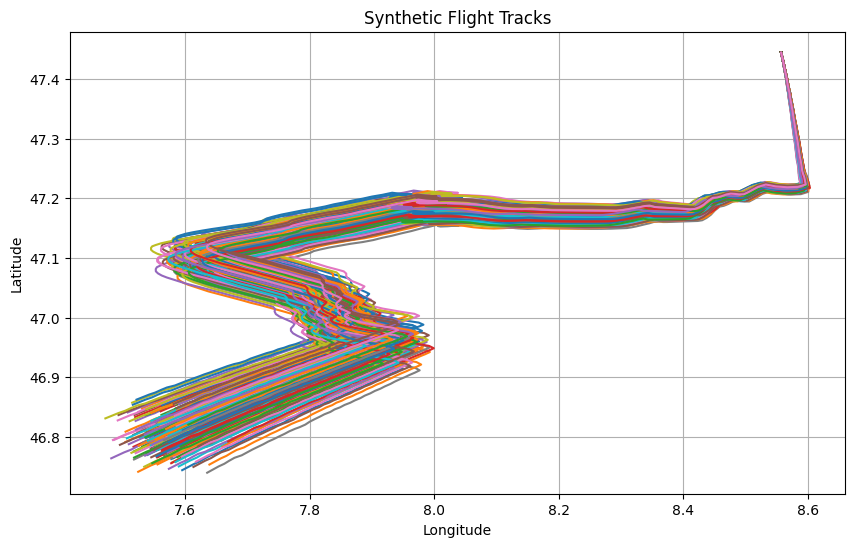

In [ ]:
# Generate synthetic tracks using the trained generator
def generate_tracks(generator, latent_dim, num_tracks):
    noise = np.random.normal(0, 1, (num_tracks, latent_dim))
    synthetic_tracks = generator.predict(noise)
    return synthetic_tracks

# Generate synthetic tracks
num_tracks = 357  # Number of tracks to generate
synthetic_tracks = generate_tracks(generator_rnn, latent_dim, num_tracks)

# Plot synthetic tracks on a map
def plot_tracks(tracks):
    plt.figure(figsize=(10, 6))
    for track in tracks:
        # Extract longitude and latitude from the track
        longitude = track[:, 0]
        latitude = track[:, 1]

        # Plot longitude vs latitude as a line
        plt.plot(longitude, latitude)

    plt.title('Synthetic Flight Tracks')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

# Plot synthetic tracks
plot_tracks(synthetic_tracks)

       Longitude   Latitude      Altitude  Groundspeed
0       7.559968  46.785568  12705.241211   230.031982
1       7.569963  46.790562  12706.754883   230.041626
2       7.579652  46.795349  12708.268555   230.024200
3       7.589424  46.799427  12709.781250   230.035721
4       7.598053  46.804256  12712.051758   230.025787
...          ...        ...           ...          ...
71395   8.562333  47.418991   1501.676392   116.518883
71396   8.561127  47.425495   1450.435669   115.632278
71397   8.559920  47.431267   1399.194946   114.805550
71398   8.558360  47.438374   1335.764282   115.221100
71399   8.556944  47.444107   1272.954102   116.129768

[71400 rows x 4 columns]


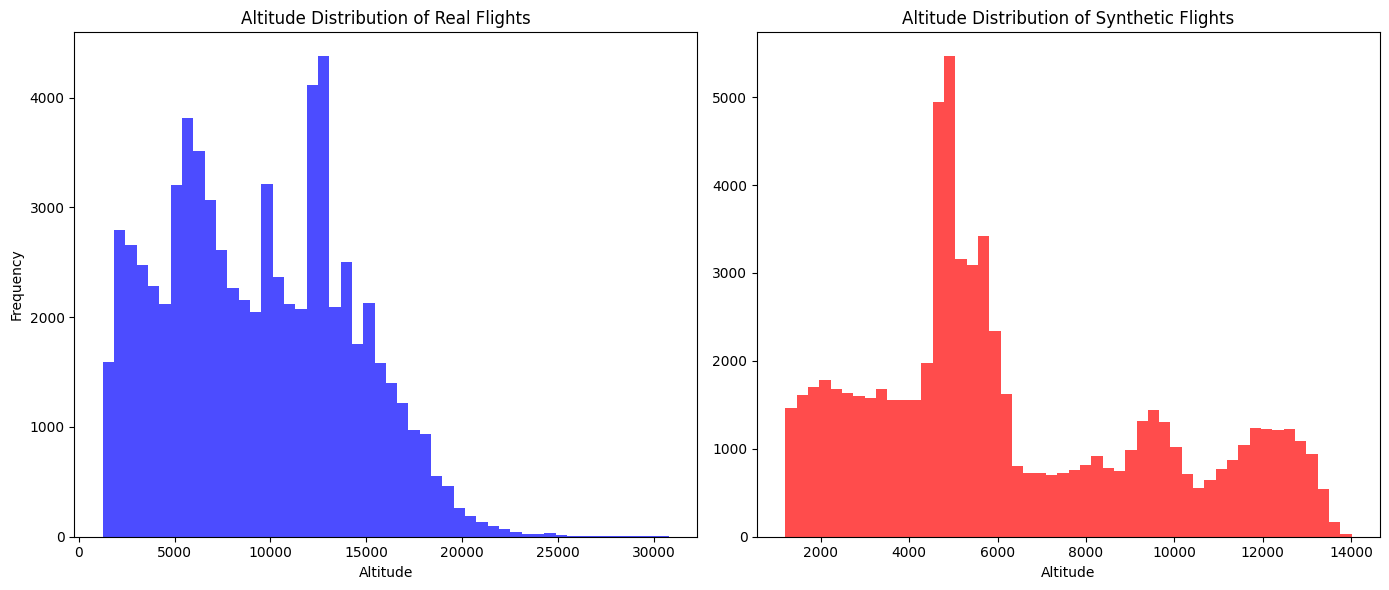

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create an empty DataFrame to store the synthetic tracks
df_columns = ['Longitude', 'Latitude', 'Altitude', 'Groundspeed']
synthetic_flights_df = pd.DataFrame(columns=df_columns)

# Iterate through each synthetic route, add them to the DataFrame without scaling
for route in synthetic_tracks:
    # Assuming route is a list or array containing [longitude, latitude, altitude, groundspeed]
    df_temp = pd.DataFrame(route, columns=df_columns)
    synthetic_flights_df = pd.concat([synthetic_flights_df, df_temp], ignore_index=True)

# Print the DataFrame containing synthetic tracks
print(synthetic_flights_df)

# Loading the datasets (assuming real_flights_df is already defined in your code)
real_flights_df = df_1.copy()

# Remove NaN values from synthetic_altitudes
synthetic_altitudes = synthetic_flights_df['Altitude'].dropna()

# Altitude Distribution for Real vs. Synthetic Flights
plt.figure(figsize=(14, 6))
real_altitudes = real_flights_df['altitude'].dropna()

plt.subplot(1, 2, 1)
plt.hist(real_altitudes, bins=50, color='blue', alpha=0.7, label='Real Flights')
plt.title('Altitude Distribution of Real Flights')
plt.xlabel('Altitude')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(synthetic_altitudes, bins=50, color='red', alpha=0.7, label='Synthetic Flights')
plt.title('Altitude Distribution of Synthetic Flights')
plt.xlabel('Altitude')

plt.tight_layout()
plt.show()

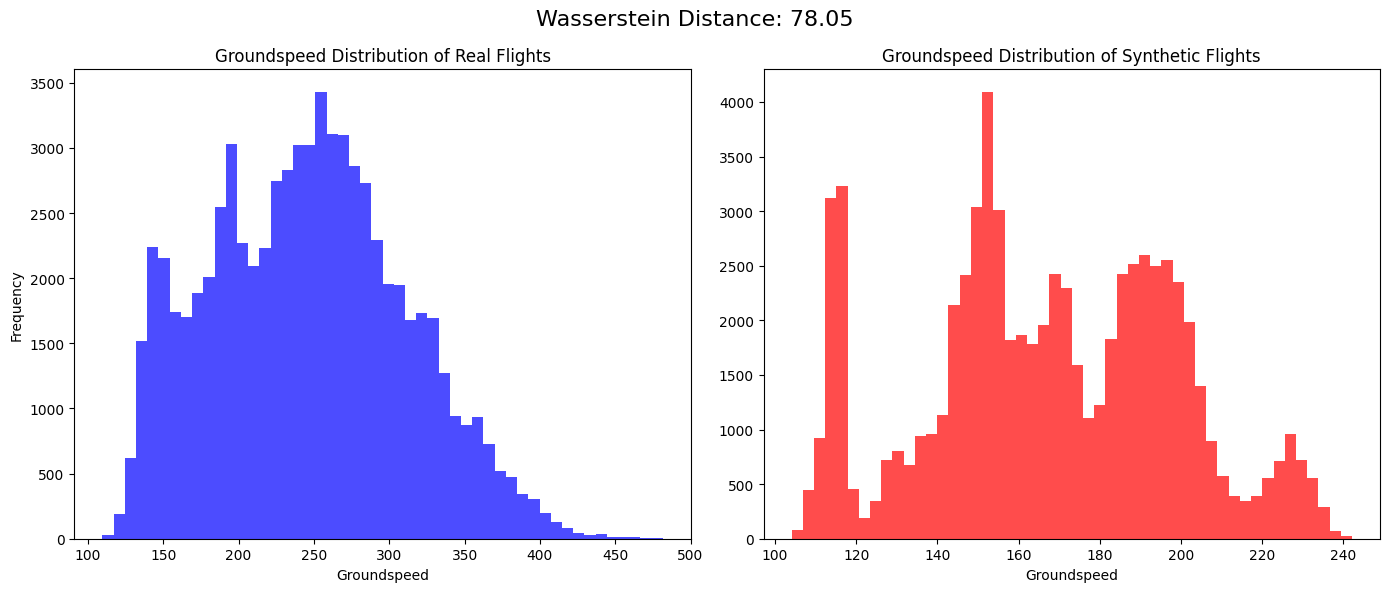

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wasserstein_distance

plt.figure(figsize=(14, 6))
synthetic_altitudes = synthetic_flights_df['Groundspeed'].dropna()
real_altitudes = real_flights_df['groundspeed'].dropna()

plt.subplot(1, 2, 1)
plt.hist(real_altitudes, bins=50, color='blue', alpha=0.7, label='Real Flights')
plt.title('Groundspeed Distribution of Real Flights')
plt.xlabel('Groundspeed')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(synthetic_altitudes, bins=50, color='red', alpha=0.7, label='Synthetic Flights')
plt.title('Groundspeed Distribution of Synthetic Flights')
plt.xlabel('Groundspeed')

# Calculate Wasserstein distance
w_distance = wasserstein_distance(real_altitudes, synthetic_altitudes)
plt.suptitle(f'Wasserstein Distance: {w_distance:.2f}', fontsize=16)

plt.tight_layout()
plt.show()